In [ ]:
!pip install tensorflow_text
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_text
import pandas as pd
import numpy as np
import tensorflow_addons as tfa

## Preprocessing

In [ ]:
# Import english sentiment
tweets = pd.read_pickle("../../Data/english_sentiment_with_confidence.pkl")
tweets.columns = ["text_clean", "iaa"] ## For simplicity rename confidence to iaa
tweets

,text_clean,iaa
0,Grilling kabobs on the grill last night was am...,0.8439
1,The slowest day ever !! And the weather makes ...,0.6963
2,Fire Weather Watch issued May 17 at 4:21PM CDT...,0.8802
3,Im going to lunch early today. The weather i...,0.6897
4,Weekend Weather Causes Delays In I-270 Bridge ...,0.6153
...,...,...
29201,By this point some of my readers will be up in...,0.4450
29202,Members of that nobility had been prominent in...,0.7879
29203,He did his best to paper over the cracks.,0.4409
29204,Heavy dependence on sponsorship and arts counc...,0.3713


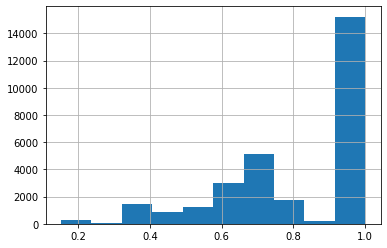

In [ ]:
tweets['iaa'].hist()

#### See distribution of difficult and easy to annotate tweets

In [ ]:
tweets['difficult'] = tweets['iaa'] < 0.9

### Calculate weights and initial bias

In [ ]:
difficult = tweets['difficult'].sum()
easy = len(tweets['difficult']) - difficult
print(f"There are {difficult} difficult to annotate tweets and {easy} easy to annotate in the dataset")

NameError: ignored

In [ ]:
total = len(tweets)
pos = tweets['difficult'].sum()
neg = total - pos

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
initial_bias = np.log([pos/neg])

### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets[['text_clean',"iaa"]], tweets['difficult'].to_numpy(), 
                                                    test_size=0.2, random_state=42, stratify = tweets['difficult'].to_numpy())

### Neural Network model

In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3', 
                        input_shape=[], 
                        dtype=tf.string, 
                        trainable=False), 
    tf.keras.layers.Dense(512, activation='relu',),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid', name="last_output")
])

### Summary of NN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               85213184  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

Compile model

In [ ]:
metrics = ['accuracy',
          tf.keras.metrics.Recall(name='recall'),
          tfa.metrics.FBetaScore(name='fbeta', beta=2.,num_classes=1, threshold=0.5)
          ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=metrics)

Create save best checkpoint - follows validation fbeta score

In [ ]:
checkpoint_filepath = './model_checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_fbeta',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(X_train["text_clean"].to_numpy(), y_train, epochs=10, batch_size=300, validation_split=0.15, class_weight=class_weight, callbacks=[model_checkpoint_callback])

Epoch 1/10
67/67 [==============================] - 69s 693ms/step - loss: 0.6158 - accuracy: 0.6652 - recall: 0.6523 - fbeta: 0.6515 - val_loss: 0.5417 - val_accuracy: 0.7121 - val_recall: 0.7262 - val_fbeta: 0.7191
Epoch 2/10
67/67 [==============================] - 41s 614ms/step - loss: 0.5506 - accuracy: 0.7064 - recall: 0.7369 - fbeta: 0.7240 - val_loss: 0.5294 - val_accuracy: 0.7104 - val_recall: 0.7250 - val_fbeta: 0.7178
Epoch 3/10
67/67 [==============================] - 41s 617ms/step - loss: 0.5331 - accuracy: 0.7150 - recall: 0.7368 - fbeta: 0.7265 - val_loss: 0.5277 - val_accuracy: 0.7210 - val_recall: 0.7020 - val_fbeta: 0.7045
Epoch 4/10
67/67 [==============================] - 44s 653ms/step - loss: 0.5213 - accuracy: 0.7245 - recall: 0.7181 - fbeta: 0.7162 - val_loss: 0.5245 - val_accuracy: 0.7224 - val_recall: 0.7333 - val_fbeta: 0.7272
Epoch 5/10
67/67 [==============================] - 41s 617ms/step - loss: 0.5089 - accuracy: 0.7382 - recall: 0.7260 - fbeta: 0.725

In [ ]:
model.load_weights("./model_checkpoint/checkpoint")

### Evaluate model

In [ ]:
test_loss = model.evaluate(X_test["text_clean"].to_numpy(), y_test)

183/183 [==============================] - 14s 75ms/step - loss: 0.5467 - accuracy: 0.7099 - recall: 0.7211 - fbeta: 0.7141


In [ ]:
predicted = model.predict(X_test["text_clean"].to_numpy())

In [ ]:
pred = [elem[0] > 0.5  for elem in predicted]

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

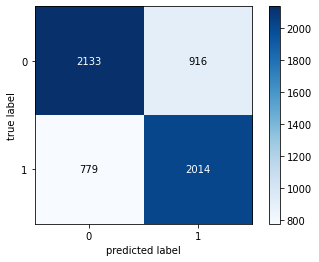

In [ ]:
cf = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=cf, colorbar=True)
plt.show()

#### Export results

In [ ]:
df = pd.DataFrame({"iaa":X_test["iaa"],"Truth":y_test, "Pred":pred, "Prob":[prob[0] for prob in predicted]})

In [ ]:
df.to_csv("/content/drive/MyDrive/Thesis/MLAlgorithms/NNModels/resultsNNEnglish.csv")